In [1]:
import numpy as np
from matplotlib import pyplot as plt
import openmc
import pandas as pd

In [2]:
energies = [0.0,1.0,2e3,3e5,2.0e6]
radius = 1000   #cm

num_threads = 16

batches = 200
num_inactive = 10
num_particles = 1000

#Example for 60% 2MeV neutrons and 40% 300 keV neutrons
#    source_strength = [2e6,3e5]
#    source_probs = [0.6,0.4]

source_strength = [2e6]  #neutron energies emitted from source
source_probs = [1]     #neutron distributions

source_rate = 1  #n/s

tally_energy_scores = ['total', 'absorption','elastic','scatter','flux']
tally_out_scores = ['elastic','scatter']
tally_surf_scores = ['current']
tally_exit_energy_scores = ['flux','events']

In [3]:
#Material Properties
aluminum = openmc.Material(name="aluminum")
aluminum.add_element('Al',1.0)
aluminum.set_density('g/cm3',2.71)
aluminum.add_s_alpha_beta("c_Al27")

materials = openmc.Materials([aluminum])
materials.export_to_xml()

In [4]:
#Create point source
energy_dist = openmc.stats.Discrete(source_strength,source_probs)
energy_dist.distribution = "discrete"
energy_dist.x = source_strength
energy_dist.p = source_probs

point = openmc.stats.Point((0,0,0))
source = openmc.Source(space=point,energy=energy_dist)
source.energy_mode = 'multi-group'
source.strength = source_rate

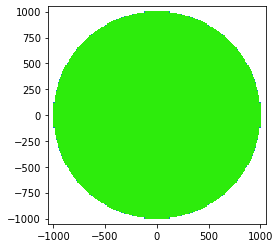

In [5]:
#Set sphere geometry and create sphere cell
sphere_geometry = openmc.Sphere(r=radius)
inside_sphere = -sphere_geometry
outside_sphere = +sphere_geometry

shell_geometry = openmc.Sphere(r=radius+1,boundary_type='vacuum')

inside_shell = -shell_geometry & outside_sphere

sphere_cell = openmc.Cell(region = inside_sphere,
                  fill = aluminum)

shell_cell = openmc.Cell(region=inside_shell)


universe = openmc.Universe(cells=[sphere_cell,shell_cell])
#universe.add_cell(sphere_cell)

geometry = openmc.Geometry()
geometry.root_universe = universe
geometry.export_to_xml()

#Plot cell
size = (radius+1) * 2.1
universe.plot(width=(size,size))
universe.plot(width=(size,size),basis="xz")

In [6]:
#Create energy filter and select tally scores
energy_filter = openmc.EnergyFilter(energies)   #Bins tally events based on incident particle energy.
out_filter = openmc.EnergyoutFilter(energies)   #Bins tally events based on outgoing particle energy
surf_filter = openmc.SurfaceFilter(sphere_geometry)
shell_cell_filter = openmc.CellFilter(shell_cell)
sphere_cell_filter = openmc.CellFilter(sphere_cell)

tally_out = openmc.Tally(tally_id = 1) 
tally_out.filters = [out_filter,sphere_cell_filter]
tally_out.scores = tally_out_scores

tally_energy = openmc.Tally(tally_id = 2)
tally_energy.filters = [energy_filter,sphere_cell_filter]
tally_energy.scores = tally_energy_scores

tally_surf = openmc.Tally(tally_id = 3)
tally_surf.filters = [surf_filter]
tally_surf.scores = tally_surf_scores

tally_exit_energy = openmc.Tally(tally_id=4)
tally_exit_energy.filters = [energy_filter,shell_cell_filter]
tally_exit_energy.scores = tally_exit_energy_scores


tallies = openmc.Tallies([tally_out,tally_energy,tally_surf,tally_exit_energy])
tallies.export_to_xml()

In [7]:
#Create settings file
settings = openmc.Settings()
settings.source = source
settings.batches = batches
settings.inactive = num_inactive
settings.particles = num_particles
settings.run_mode = 'fixed source'
settings.export_to_xml()

In [8]:
#Run simulation
openmc.run(threads=num_threads)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [9]:
with openmc.StatePoint('statepoint.' + str(batches) + '.h5') as sp:
    # Get the OpenMC pin power tally data
    tally_out = sp.get_tally(id=1)
    tally_energy = sp.get_tally(id=2)
    tally_surf = sp.get_tally(id=3)
    tally_exit_energy = sp.get_tally(id=4)
    
print("Scores are in units reaction/source particles")
print("Flux score is in units of particle-cm/source particle")
print("Events score is in units of events/source particle")
    
leakage = tally_surf.get_values(scores=['current'])[0][0][0]
print(f"{leakage} out of {source_rate} particles escaped through the sphere boundary")
#print("*"*80)
tallies_list = [tally_energy,tally_out,tally_exit_energy]
dict_list = []
description_list = ["Neutrons within sphere with incident energies in certain bins","Neutrons which left interactions with energies in certain bins",
                    "Neutrons which escaped the sphere"]
for i,tally in enumerate(tallies_list):
    print("*"*80,"\n")
    print(description_list[i])
    scores_dict = {"Bin" : np.linspace(len(energies)-1,1,len(energies)-1)}
    scores_dict["E_min [ev]"] = energies[:-1]
    scores_dict["E_max [ev]"] = energies[1:]

    scores_list = tally.scores
    
    for score in scores_list:
        #print(score)
        #print("E_min (ev)\t E_max (ev)\tValue")
        #for count,energy in enumerate(energies[:-1]):
        #    print(format(energy,"1.2e"),"\t",format(energies[count+1],"1.2e"),"\t",score_val[count][0][0])
        #print()
        score_val = tally.get_values(scores=[score])
        asdf = [i for i in score_val]
        asdf = [i for i in asdf]

        scores_dict[score] = [i[0][0] for i in score_val]

    dict_list.append(scores_dict)
    scores_df = pd.DataFrame(scores_dict)
    
    display(scores_df)
    print()
    


Scores are in units reaction/source particles
Flux score is in units of particle-cm/source particle
Events score is in units of events/source particle
0.0 out of 1 particles escaped through the sphere boundary
******************************************************************************** 

Neutrons within sphere with incident energies in certain bins


,Bin,E_min [ev],E_max [ev],total,absorption,"(n,elastic)",scatter,flux
0,4.0,0.0,1.0,9.767264,0.462178,9.305086,9.305086,114.018359
1,3.0,1.0,2000.0,85.106628,0.481079,84.625549,84.625549,998.396228
2,2.0,2000.0,300000.0,66.965038,0.054107,66.910931,66.910931,760.364626
3,1.0,300000.0,2000000.0,22.455722,0.003044,21.731150,22.452678,110.166758



******************************************************************************** 

Neutrons which left interactions with energies in certain bins


,Bin,E_min [ev],E_max [ev],"(n,elastic)",scatter
0,4.0,0.0,1.0,9.768990,9.768990
1,3.0,1.0,2000.0,85.122665,85.122665
2,2.0,2000.0,300000.0,66.847050,66.933645
3,1.0,300000.0,2000000.0,20.830050,21.464845



******************************************************************************** 

Neutrons which escaped the sphere


,Bin,E_min [ev],E_max [ev],flux,events
0,4.0,0.0,1.0,0.0,0.0
1,3.0,1.0,2000.0,0.0,0.0
2,2.0,2000.0,300000.0,0.0,0.0
3,1.0,300000.0,2000000.0,0.0,0.0


The two filters tally number of interactions of certain types based on neutron energy. The first only counts scattering, absorption, etc interactions when the incident neutron is in a certain energy bin. The second filter only counts an interaction when the neutron leaving the interaction has an energy within a certain bin.  
The number of neutrons which scatter from one energy bin to another is equal to the count of neutrons whose incident energy lies within a certain bin minus the count of neutrons whose leaving energy is still within that bin.  

$\Sigma_{1->2} = $

In [11]:
(inc_dict,out_dict,esc_dict) = dict_list[:]
#print(inc_dict)
scat_dif_list = []
scat_inc = inc_dict['scatter']
abs_inc = inc_dict['absorption']
scat_out = out_dict['scatter']
esc_dict = esc_dict['events']
downscat_list = [scat_inc[-1] - scat_out[-1]]
abs_list = [source_rate - downscat_list[0] - esc_dict[-1]]

amt_removed_list = [abs_inc[-1] + esc_dict[-1]]
for i in range(1,len(energies)-1):
    downscat = scat_inc[-i-1]-scat_out[-i-1] + downscat_list[i-1]
    #print(downscat)
    downscat_list.append(downscat)
    amt_removed_list.append(abs_inc[-1-i] + esc_dict[-1-i] + amt_removed_list[i-1])
print(downscat_list)
print(abs_list)
print(abs_inc)
print(amt_removed_list)
print()
"""downscat_rate = scat_inc[-1] - scat_out[-1] 
print(downscat_rate)
print(scat_inc[-2]-downscat_rate,scat_out[-2])"""
#find number of scattering events which resulted in downscattering from the highest bin
#print(scat_inc[-1] - scat_out[-1] - esc_dict[-1] + abs_inc[-1])
for i in range(4):
    print(downscat_list[i] + abs_inc[3-i])

"""for i in range(len(energies)-1):
    scat_dif_list.append(inc_dict['scatter'][i] - out_dict['scatter'][i] - esc_dict['events'][i])
    
print(scat_dif_list)"""

[0.98783305312217, 0.9651187289184513, 0.4680025188088983, 0.0040984675995066056]
[0.012166946877830043]
[0.46217767862868114, 0.4810792333823578, 0.054107102485841725, 0.0030435594686334185]
[0.0030435594686334185, 0.05715066195447514, 0.538229895336833, 1.000407573965514]

0.9908766125908034
1.019225831404293
0.9490817521912561
0.46627614622818775


"for i in range(len(energies)-1):\n    scat_dif_list.append(inc_dict['scatter'][i] - out_dict['scatter'][i] - esc_dict['events'][i])\n    \nprint(scat_dif_list)"

In [180]:
for i in np.linspace(len(energies)-2,0,len(energies)-1):
    print(i)

3.0
2.0
1.0
0.0


In [17]:
scores_dict = {"Bin" : np.linspace(len(energies)-1,1,len(energies)-1)}
scores_dict["E_min [ev]"] = energies[:-1]
scores_dict["E_max [ev]"] = energies[1:]

scores_list = tally_out.scores
print("Scores are in units reaction/source particle")
print("Flux score is in units of particle-cm/source particle")
for score in scores_list:
    print(score)
    print("E_min (ev)\t E_max (ev)\tValue")
    score_val = tally.get_values(scores=[score])
    asdf = [i for i in score_val]
    asdf = [i for i in asdf]

    scores_dict[score] = [i[0][0] for i in score_val]
    
    for count,energy in enumerate(energies[:-1]):
        
        print(format(energy,"1.2e"),"\t",format(energies[count+1],"1.2e"),"\t",score_val[count][0][0])
    print()
    
scores_df = pd.DataFrame(scores_dict)

display(scores_df)

Scores are in units reaction/source particle
Flux score is in units of particle-cm/source particle
(n,elastic)
E_min (ev)	 E_max (ev)	Value
0.00e+00 	 1.00e+00 	 0.9229999999999988
1.00e+00 	 2.00e+03 	 180.2168999999994
2.00e+03 	 3.00e+05 	 3877.0845999999988
3.00e+05 	 2.00e+06 	 2167.838599999999

scatter
E_min (ev)	 E_max (ev)	Value
0.00e+00 	 1.00e+00 	 0.9229999999999988
1.00e+00 	 2.00e+03 	 180.2168999999994
2.00e+03 	 3.00e+05 	 3877.0845999999988
3.00e+05 	 2.00e+06 	 2239.94315



,Bin,E_min [ev],E_max [ev],"(n,elastic)",scatter
0,4.0,0.0,1.0,0.9230,0.92300
1,3.0,1.0,2000.0,180.2169,180.21690
2,2.0,2000.0,300000.0,3877.0846,3877.08460
3,1.0,300000.0,2000000.0,2167.8386,2239.94315


In [17]:
with openmc.StatePoint('statepoint.' + str(batches) + '.h5') as sp:
    # Get the OpenMC pin power tally data
    tally = sp.get_tally()
    
scores_dict = {"Bin" : np.linspace(len(energies)-1,1,len(energies)-1)}
scores_dict["E_min [ev]"] = energies[:-1]
scores_dict["E_max [ev]"] = energies[1:]

scores_list = tally.scores
for score in scores_list:
    print(score)
    print("E_min (ev)\t E_max (ev)\tValue")
    score_val = tally.get_values(scores=[score])
    asdf = [i for i in score_val]
    asdf = [i for i in asdf]

    scores_dict[score] = [i[0][0] for i in score_val]
    
    for count,energy in enumerate(energies[:-1]):
        
        print(format(energy,"1.2e"),"\t",format(energies[count+1],"1.2e"),"\t",score_val[count][0][0])
    print()
    
scores_df = pd.DataFrame(scores_dict)

display(scores_df)

total
E_min (ev)	 E_max (ev)	Value
0.00e+00 	 1.00e+00 	 0.011913
1.00e+00 	 2.00e+03 	 2.156625
2.00e+03 	 3.00e+05 	 42.61438099999999
3.00e+05 	 2.00e+06 	 2.231758

absorption
E_min (ev)	 E_max (ev)	Value
0.00e+00 	 1.00e+00 	 0.000493
1.00e+00 	 2.00e+03 	 0.004176999999999999
2.00e+03 	 3.00e+05 	 0.02563100000000002
3.00e+05 	 2.00e+06 	 0.00028400000000000024

(n,elastic)
E_min (ev)	 E_max (ev)	Value
0.00e+00 	 1.00e+00 	 0.011420000000000003
1.00e+00 	 2.00e+03 	 2.1524480000000015
2.00e+03 	 3.00e+05 	 42.58875
3.00e+05 	 2.00e+06 	 2.1596959999999994

scatter
E_min (ev)	 E_max (ev)	Value
0.00e+00 	 1.00e+00 	 0.011420000000000003
1.00e+00 	 2.00e+03 	 2.1524480000000015
2.00e+03 	 3.00e+05 	 42.58875
3.00e+05 	 2.00e+06 	 2.2314740000000004

nu-scatter
E_min (ev)	 E_max (ev)	Value
0.00e+00 	 1.00e+00 	 0.011420000000000003
1.00e+00 	 2.00e+03 	 2.1524480000000015
2.00e+03 	 3.00e+05 	 42.58875
3.00e+05 	 2.00e+06 	 2.2314740000000004



,Bin,E_min [ev],E_max [ev],total,absorption,"(n,elastic)",scatter,nu-scatter
0,4.0,0.0,1.0,0.011913,0.000493,0.011420,0.011420,0.011420
1,3.0,1.0,2000.0,2.156625,0.004177,2.152448,2.152448,2.152448
2,2.0,2000.0,300000.0,42.614381,0.025631,42.588750,42.588750,42.588750
3,1.0,300000.0,2000000.0,2.231758,0.000284,2.159696,2.231474,2.231474


In [11]:
groups = openmc.mgxs.EnergyGroups(np.logspace(-5,7,8))
al_xsdata = openmc.XSdata('al27',groups)
al_xsdata.order = 0